<a href="https://colab.research.google.com/github/Patrick5455/Customer-Churn-Prediction/blob/master/modelling/customer_churn_modelling_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive  
drive.mount('/content/drive')  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import some libraries
import pandas as pd
from pandas.api.types import is_string_dtype 
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt 
from pylab import rcParams  
import seaborn as sns 
import os 
sns.set_style('darkgrid')
rcParams['figure.figsize'] = 8,8
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


> Data Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import IsolationForest 
from imblearn.over_sampling import SMOTE

Modelling

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import  Pipeline as ImbPipe
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import scorer, log_loss
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, plot_roc_curve, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
import sklearn
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import RFECV
# from sklearn.feature_extraction import 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, chi2, SelectPercentile

from sklearn.compose import make_column_selector as selector

from sklearn.svm import SVC

In [ ]:
# sklearn.feature_extraction.

> > Project packages

In [ ]:
# from project_package.data_package import data
# from project_package.model_package import model, model_metrics
# from project_package.plot_package import bi_plot, uni_plot
# 

In [ ]:
# ?KNNImputer

> Load Datasets

In [ ]:
#g-drive paths
train = '/content/drive/My Drive/Zindi-Competionts/customer-churn-prediction/datasets/AIMS_Train.csv'
test = '/content/drive/My Drive/Zindi-Competionts/customer-churn-prediction/datasets/AIMS_Test.csv'
variables = '/content/drive/My Drive/Zindi-Competionts/customer-churn-prediction/datasets/VariableDefinitions.csv'
submissions = '/content/drive/My Drive/Zindi-Competionts/customer-churn-prediction/datasets/AIMS_SampleSubmission.csv' 

In [ ]:
#colab
train = pd.read_csv(train)
test=  pd.read_csv(test)
submission = pd.read_csv(submissions)
variables = pd.read_csv(variables, header=2)

In [ ]:
#import data - jupyter localhost

# train = pd.read_csv('../datasets/AIMS_Train.csv')
# test=  pd.read_csv('../datasets/AIMS_Test.csv')
# submission = pd.read_csv('../datasets/AIMS_SampleSubmission.csv')
# variables = pd.read_csv('../datasets/VariableDefinitions.csv')

#### Define Utility Functions

> Calculate number of levels in categorical variables

In [ ]:
def check_levels(data, exclude_cols=[]):
    cat_cols = data.select_dtypes(include='object').columns.tolist()
    
    for col in cat_cols:
        if col not in exclude_cols:
            print('*-*'*10,'\n')
            print(data[col].value_counts())
            plt.figure(figsize=(10,5)) 
            plt.title(f"Value Counts of {col}", fontsize=15)
            data[col].value_counts(normalize=True).plot(kind='bar')
            print('*-*'*10,'\n')
            plt.ylabel('counts')
            plt.xlabel(col)

> check for null values

In [ ]:
def check_null(data, plot=True):
    print(data.isnull().sum()) 
    if plot:
        plt.figure(figsize=(10,5))
        plt.title(f"Null Values Count", fontsize=15)
        data.isnull().sum().plot.bar()

> check for outliers

In [ ]:
def check_outliers(data, show_plot=False, save_img=os.getcwd()+'/outliers.png'):
 
        """
        This functions checks for columns with outlers using the IQR method

        It accespts as argmuent a dataset. 
        show_plot can be set to True to output pairplots of outlier columns    
        """

        outliers = [] 
        Q1 = data.quantile(0.25)  
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1 
        num_data = data.select_dtypes(include=['float64', 'int64'])
        result = dict (((num_data < (Q1 - 1.5 * IQR)) | (num_data > (Q3 + 1.5 * IQR))).any())
        print(result)  
        index = data[(num_data < Q1 - 1.5 * IQR) | (num_data > Q3 + 1.5 * IQR)].index
        for k,v in result.items(): 
            if v == True:  
                outliers.append(k) 
        if show_plot:
            outlier_pair_plot = sns.pairplot(data[outliers]); 
            print(f'{result},\n\n Visualization of outlier columns')
            plt.savefig(fname=save_img, format='png')
            return  outlier_pair_plot
        else:
            print(data.shape)
            return data.loc[index, outliers] 

> Define functions to mesaure predictions performance


In [ ]:
class PredMetrics():

  def __init__(self, X, y, y_pred, y_true, model, scorer:make_scorer,
                 verbose=False, cv=StratifiedKFold(random_state=123)):
    
    self.X = X 
    self.y = y
    self.y_pred = y_pred
    self.y_true = y_true
    self.model = model
    self.scorer = scorer
    self.cv = cv 

  def __repr__(self):
    return "Prediction Metrics"

  
  def cv_score(self):

     self.cv_score_metric = cross_val_score(model = self.model, X=self.X, y=self.y, scoring = self.scorer, verbose=verbose, cv=self.cv)

     return self.cv_score_metric

  def conf_matrix(self):

    self.conf_matrix_metric = confusion_matrix(y_true=self.y_true, y_pred=self.y_pred)

    return self.conf_matrix_metric

  def log_loss_score(self):

    self.log_loss_metric = log_loss(y_true = self.y_true, y_pred = self.y_pred)

    return self.log_loss_metric

  def roc_curve(self):

    self.plot_roc_metric = plot_roc_curve(self.model, X=self.X, y = self.y)
      
    return self.plot_roc_metric
  
  def class_report(self):

    self.class_report_metric = classification_report_imbalanced(y_true = self.y_true, y_pred = self.y_pred)

    return self.class_report_metric

> Define functions to save satisifed predictions

In [ ]:
def save_pred(y_hat, test_set, file_name ="new_submission"):
  prediction_path = '/content/drive/My Drive/Zindi-Competionts/zimnat_Challenge_predicting_insurance_purchase/submissions/'
  from datetime import datetime
  file_name=file_name+datetime.now().strftime('%Y-%m-%d')
  submissions = pd.DataFrame({'ID X PCODE':test_set['ID X PCODE'],'Label':y_hat})
  submissions.to_csv(prediction_path+file_name, index=False)
  return submissons 

#### Define Custom Estimators

In [ ]:
variables

,Unnamed: 0,Le dataset churn comprend 19 variables dont 15 variables numeriques et 04 variables categoriques.,The churn dataset includes 19 variables including 15 numeric variables and 04 categorical variables.
0,user_id,NaN,NaN
1,REGION,la localité de chaque client,the location of each client
2,TENURE,la durée dans le reseau,duration in the network
3,MONTANT,montant de recharge,top-up amount
4,FREQUENCE_RECH,nombre de fois que le client a fait une recharge,number of times the customer refilled
5,REVENUE,revenu mensuel de chaque client,monthly income of each client
6,ARPU_SEGMENT,revenu sur 90 jours/3,income over 90 days / 3
7,FREQUENCE,nombre de fois que client à fait un revenu,number of times the client has made an income
8,DATA_VOLUME,nombre de connexions,number of connections
9,ON_NET,appel inter expresso,inter expresso call


In [ ]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646214 entries, 0 to 646213
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         646214 non-null  object 
 1   REGION          391246 non-null  object 
 2   TENURE          646214 non-null  object 
 3   MONTANT         419154 non-null  float64
 4   FREQUENCE_RECH  419154 non-null  float64
 5   REVENUE         428459 non-null  float64
 6   ARPU_SEGMENT    428459 non-null  float64
 7   FREQUENCE       428459 non-null  float64
 8   DATA_VOLUME     327544 non-null  float64
 9   ON_NET          409962 non-null  float64
 10  ORANGE          377516 non-null  float64
 11  TIGO            259060 non-null  float64
 12  ZONE1           50406 non-null   float64
 13  ZONE2           41072 non-null   float64
 14  MRG             646214 non-null  object 
 15  REGULARITY      646214 non-null  int64  
 16  TOP_PACK        375331 non-null  object 
 17  FREQ_TOP_P

In [ ]:
# train.drop(columns=['REGION', 'TOP_PACK', 'MRG'], inplace=True) 
train = train.sample(frac=.3, random_state=123) 
train.head() 

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
542316,16a8528ec3b1201f5cb8bfc35533744b79bd44d2,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN,1
59878,3a8b710546fb6272a56908c2fcbcef20e2caa0cf,THIES,K > 24 month,11650.0,30.0,11682.0,3894.0,32.0,7119.0,23.0,468.0,54.0,0.0,NaN,NO,60,Jokko_Daily,18.0,0
10729,0f34b0bf4dac19dd901b7e03dd79cb79ed0b744a,SAINT-LOUIS,K > 24 month,1000.0,2.0,1000.0,333.0,2.0,NaN,7.0,45.0,NaN,NaN,NaN,NO,22,All-net 500F=2000F;5d,2.0,0
456437,dc34cfe39e89bddddf7f7550431681b6fc31e72e,KAOLACK,K > 24 month,500.0,1.0,480.0,160.0,4.0,1875.0,14.0,1.0,NaN,NaN,NaN,NO,20,"Data: 100 F=40MB,24H",2.0,0
273902,3920ace4d36a498dde155bec15757407846258fc,NaN,K > 24 month,11150.0,34.0,11750.0,3917.0,40.0,789.0,125.0,303.0,29.0,0.0,NaN,NO,46,On net 200F=Unlimited _call24H,31.0,0


In [ ]:
train.tail()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
392679,48d344fd728daa817fdcc1d5b42c24bf9ca40227,LOUGA,K > 24 month,500.0,1.0,500.0,167.0,1.0,0.0,9.0,8.0,15.0,NaN,NaN,NO,20,All-net 500F=2000F;5d,1.0,0
494369,b8ee2c6522cb33c8a167a6978972fce2b705f8a6,DAKAR,K > 24 month,1100.0,3.0,1098.0,366.0,3.0,216.0,27.0,1.0,2.0,NaN,NaN,NO,20,"Data: 100 F=40MB,24H",2.0,0
59888,efaef8feb41c744fe8dbc5c8a05eb323ebb13a1a,THIES,K > 24 month,1000.0,2.0,1000.0,333.0,2.0,NaN,34.0,43.0,2.0,NaN,NaN,NO,13,All-net 500F =2000F_AllNet_Unlimited,1.0,0
561559,0042094e077ec75af7ded7e3ec662c421d93d242,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,2,NaN,NaN,1
379331,69c3b8e7dd5e9d374e771be2e11c0b27be804523,DAKAR,K > 24 month,7200.0,16.0,7190.0,2397.0,18.0,5284.0,7.0,83.0,NaN,NaN,0.0,NO,60,"Data:490F=1GB,7d",8.0,0


In [ ]:
train.shape

(193864, 19)

In [ ]:
#view the data types in the train data
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193864 entries, 542316 to 379331
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         193864 non-null  object 
 1   REGION          117130 non-null  object 
 2   TENURE          193864 non-null  object 
 3   MONTANT         125596 non-null  float64
 4   FREQUENCE_RECH  125596 non-null  float64
 5   REVENUE         128373 non-null  float64
 6   ARPU_SEGMENT    128373 non-null  float64
 7   FREQUENCE       128373 non-null  float64
 8   DATA_VOLUME     97818 non-null   float64
 9   ON_NET          122924 non-null  float64
 10  ORANGE          113127 non-null  float64
 11  TIGO            77925 non-null   float64
 12  ZONE1           15235 non-null   float64
 13  ZONE2           12164 non-null   float64
 14  MRG             193864 non-null  object 
 15  REGULARITY      193864 non-null  int64  
 16  TOP_PACK        112372 non-null  object 
 17  FREQ_

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114038 entries, 0 to 114037
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         114038 non-null  object 
 1   REGION          69081 non-null   object 
 2   TENURE          114038 non-null  object 
 3   MONTANT         74135 non-null   float64
 4   FREQUENCE_RECH  74135 non-null   float64
 5   REVENUE         75854 non-null   float64
 6   ARPU_SEGMENT    75854 non-null   float64
 7   FREQUENCE       75854 non-null   float64
 8   DATA_VOLUME     58049 non-null   float64
 9   ON_NET          72436 non-null   float64
 10  ORANGE          66823 non-null   float64
 11  TIGO            45908 non-null   float64
 12  ZONE1           9011 non-null    float64
 13  ZONE2           7217 non-null    float64
 14  MRG             114038 non-null  object 
 15  REGULARITY      114038 non-null  int64  
 16  TOP_PACK        66425 non-null   object 
 17  FREQ_TOP_P

In [ ]:
# test.drop(columns=['REGION', 'TOP_PACK', 'MRG'], inplace=True) 
test = test.sample(frac=.3, random_state=123)
test.head()  

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
105281,e66972d08a6e90ca121fc74275e1e4adc7770fc3,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN
22722,bf9be697fbd32dc7b8ab3073ee4d3bbbcad6dfe9,TAMBACOUNDA,K > 24 month,7900.0,16.0,7900.0,2633.0,15.0,25.0,228.0,271.0,5.0,NaN,NaN,NO,62,MIXT:500F= 2500F on net _2500F off net;2d,14.0
76446,1e7202861abcaf7e0eea63032254eacf26bb098d,THIES,K > 24 month,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NO,23,NaN,NaN
46673,f4eed3780dbca03e08c43adfcf0a9463368358d9,DAKAR,H 15-18 month,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NO,62,NaN,NaN
7006,e71d6090175d55f4b7f3abc99e5f1823616960f0,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,5,NaN,NaN


In [ ]:
test.tail()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
7008,5ecbf66d9bb8b8642ef1e5fc8c9d844989376589,DIOURBEL,K > 24 month,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NO,8,NaN,NaN
71490,c3a0be58c8dee43c1c5df623c289d166a7014a10,DAKAR,K > 24 month,3800.0,5.0,3800.0,1267.0,4.0,6101.0,28.0,16.0,NaN,NaN,1.0,NO,33,"Data:1000F=5GB,7d",3.0
78321,d36271d90f822c1da3e3d531136bb9a19d577be3,NaN,K > 24 month,14150.0,31.0,15548.0,5183.0,38.0,4865.0,248.0,1040.0,73.0,NaN,NaN,NO,60,Jokko_Daily,20.0
83665,5a3e2643344a107f4050fce01d92152c12581c1f,KAFFRINE,K > 24 month,6150.0,14.0,6151.0,2050.0,19.0,300.0,129.0,43.0,1.0,NaN,NaN,NO,62,All-net 500F=2000F;5d,4.0
93996,b62f0fad5ca231131cb18c04156b21cad268abe9,THIES,K > 24 month,2900.0,13.0,2901.0,967.0,17.0,1217.0,NaN,NaN,NaN,NaN,1.0,NO,35,"Data: 200 F=100MB,24H",12.0


In [ ]:
test.shape 

(34211, 18)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34211 entries, 105281 to 93996
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         34211 non-null  object 
 1   REGION          20675 non-null  object 
 2   TENURE          34211 non-null  object 
 3   MONTANT         22363 non-null  float64
 4   FREQUENCE_RECH  22363 non-null  float64
 5   REVENUE         22854 non-null  float64
 6   ARPU_SEGMENT    22854 non-null  float64
 7   FREQUENCE       22854 non-null  float64
 8   DATA_VOLUME     17430 non-null  float64
 9   ON_NET          21735 non-null  float64
 10  ORANGE          20166 non-null  float64
 11  TIGO            13865 non-null  float64
 12  ZONE1           2736 non-null   float64
 13  ZONE2           2222 non-null   float64
 14  MRG             34211 non-null  object 
 15  REGULARITY      34211 non-null  int64  
 16  TOP_PACK        20011 non-null  object 
 17  FREQ_TOP_PACK   20011 non-

In [ ]:
submission.head()

,user_id,CHURN
0,c1b31e7cef249f2b777d934886b787a433029263,0
1,c205f3aff8486b0bed1051f3bf25fe04df7f671e,0
2,d743faaf50bbc43e02a08a2c2f4326f6d368fb25,0
3,c4e45ed21d5e2f64146b95fecbbb6b24740f803c,0
4,96c6a822243654ae1fe5f5f887089681f806cb46,0


In [ ]:
submission.shape

(114038, 2)

#### Data Wrangling

> calculate number of levels in columns

*-**-**-**-**-**-**-**-**-**-* 

DAKAR          46276
THIES          16134
SAINT-LOUIS    10722
LOUGA           8812
KAOLACK         8796
DIOURBEL        5929
TAMBACOUNDA     4924
KAFFRINE        4028
KOLDA           3328
FATICK          3259
MATAM           2601
ZIGUINCHOR      1934
SEDHIOU          314
KEDOUGOU          73
Name: REGION, dtype: int64
*-**-**-**-**-**-**-**-**-**-* 

*-**-**-**-**-**-**-**-**-**-* 

K > 24 month     183934
I 18-21 month      4089
H 15-18 month      2326
G 12-15 month      1274
J 21-24 month      1173
F 9-12 month        843
E 6-9 month         161
D 3-6 month          64
Name: TENURE, dtype: int64
*-**-**-**-**-**-**-**-**-**-* 

*-**-**-**-**-**-**-**-**-**-* 

NO    193864
Name: MRG, dtype: int64
*-**-**-**-**-**-**-**-**-**-* 

*-**-**-**-**-**-**-**-**-**-* 

All-net 500F=2000F;5d             28722
On net 200F=Unlimited _call24H    13589
Data:490F=1GB,7d                  10286
Data: 100 F=40MB,24H               7608
Mixt 250F=Unlimited_call24H     

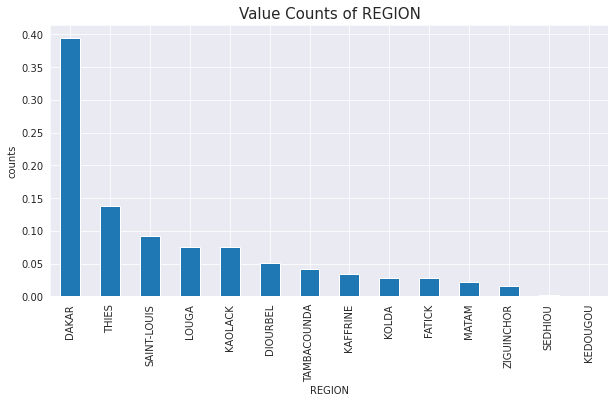

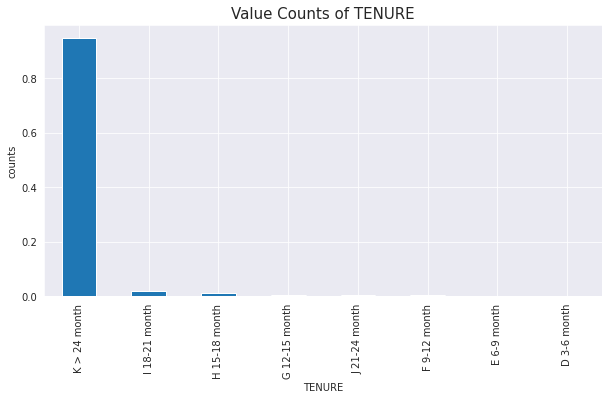

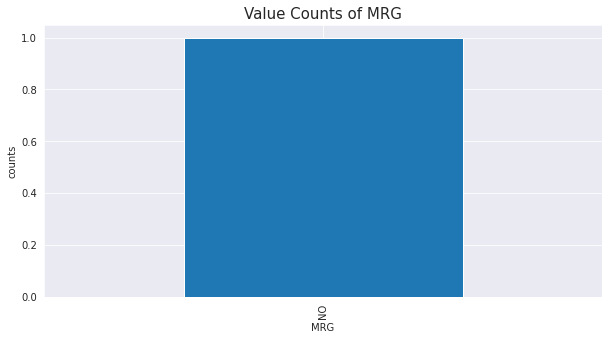

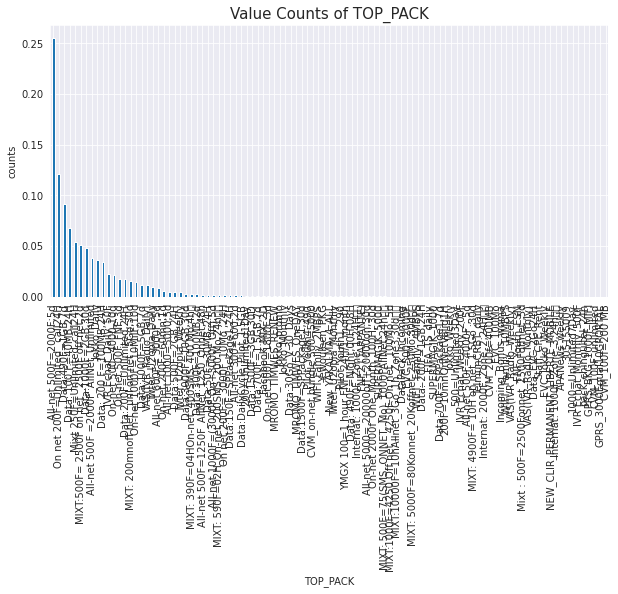

In [ ]:
check_levels(train, exclude_cols=['user_id']) 

Compute statistics for numerical variables

In [ ]:
train.describe()  

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,CHURN
count,125596.000000,125596.000000,128373.000000,128373.000000,128373.000000,9.781800e+04,122924.000000,113127.000000,77925.000000,15235.000000,12164.000000,193864.000000,112372.000000,193864.000000
mean,5549.417577,11.577136,5527.767950,1842.596769,14.013508,3.387234e+03,277.213791,95.928196,23.179865,7.688809,7.416557,27.984474,9.306633,0.188441
std,7171.390426,13.345354,7230.871687,2410.285753,14.770293,1.341194e+04,881.638677,203.990359,64.525694,34.843203,31.821617,22.276647,12.302007,0.391065
min,10.000000,1.000000,1.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,1000.000000,2.000000,1000.000000,333.000000,3.000000,0.000000e+00,5.000000,7.000000,2.000000,0.000000,0.000000,6.000000,2.000000,0.000000
50%,3000.000000,7.000000,3000.000000,1000.000000,9.000000,2.670000e+02,27.000000,29.000000,6.000000,1.000000,2.000000,24.000000,5.000000,0.000000
75%,7400.000000,16.000000,7402.000000,2467.000000,20.000000,2.918000e+03,157.000000,100.000000,20.000000,3.000000,5.000000,50.000000,12.000000,0.000000
max,256000.000000,115.000000,219423.000000,73141.000000,91.000000,1.238915e+06,36687.000000,6211.000000,3658.000000,1730.000000,1796.000000,62.000000,544.000000,1.000000


> Check for null values

user_id                0
REGION             76734
TENURE                 0
MONTANT            68268
FREQUENCE_RECH     68268
REVENUE            65491
ARPU_SEGMENT       65491
FREQUENCE          65491
DATA_VOLUME        96046
ON_NET             70940
ORANGE             80737
TIGO              115939
ZONE1             178629
ZONE2             181700
MRG                    0
REGULARITY             0
TOP_PACK           81492
FREQ_TOP_PACK      81492
CHURN                  0
dtype: int64


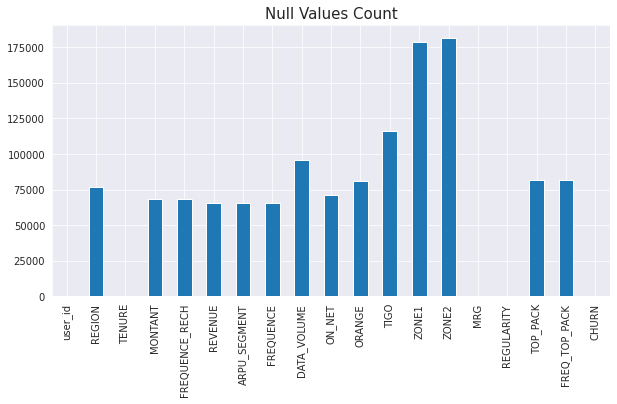

In [ ]:
check_null(train)

user_id               0
REGION            13536
TENURE                0
MONTANT           11848
FREQUENCE_RECH    11848
REVENUE           11357
ARPU_SEGMENT      11357
FREQUENCE         11357
DATA_VOLUME       16781
ON_NET            12476
ORANGE            14045
TIGO              20346
ZONE1             31475
ZONE2             31989
MRG                   0
REGULARITY            0
TOP_PACK          14200
FREQ_TOP_PACK     14200
dtype: int64


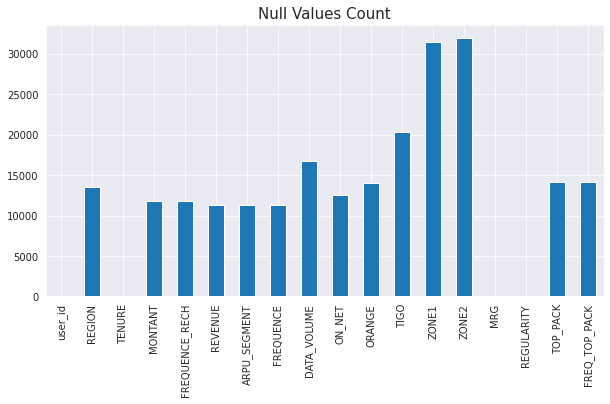

In [ ]:
check_null(test)

> There are a lot of null values in the dataset

outliers in train set

In [ ]:
check_outliers(train, show_plot=False)  

{'MONTANT': True, 'FREQUENCE_RECH': True, 'REVENUE': True, 'ARPU_SEGMENT': True, 'FREQUENCE': True, 'DATA_VOLUME': True, 'ON_NET': True, 'ORANGE': True, 'TIGO': True, 'ZONE1': True, 'ZONE2': True, 'REGULARITY': False, 'FREQ_TOP_PACK': True, 'CHURN': True}
(193864, 19)


,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,FREQ_TOP_PACK,CHURN
542316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
59878,11650.0,30.0,11682.0,3894.0,32.0,7119.0,23.0,468.0,54.0,0.0,NaN,18.0,0
10729,1000.0,2.0,1000.0,333.0,2.0,NaN,7.0,45.0,NaN,NaN,NaN,2.0,0
456437,500.0,1.0,480.0,160.0,4.0,1875.0,14.0,1.0,NaN,NaN,NaN,2.0,0
273902,11150.0,34.0,11750.0,3917.0,40.0,789.0,125.0,303.0,29.0,0.0,NaN,31.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
392679,500.0,1.0,500.0,167.0,1.0,0.0,9.0,8.0,15.0,NaN,NaN,1.0,0
494369,1100.0,3.0,1098.0,366.0,3.0,216.0,27.0,1.0,2.0,NaN,NaN,2.0,0
59888,1000.0,2.0,1000.0,333.0,2.0,NaN,34.0,43.0,2.0,NaN,NaN,1.0,0
561559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


> most columns in the train set contain outlier values

outliers in test set

In [ ]:
check_outliers(test, show_plot=False)   

{'MONTANT': True, 'FREQUENCE_RECH': True, 'REVENUE': True, 'ARPU_SEGMENT': True, 'FREQUENCE': True, 'DATA_VOLUME': True, 'ON_NET': True, 'ORANGE': True, 'TIGO': True, 'ZONE1': True, 'ZONE2': True, 'REGULARITY': False, 'FREQ_TOP_PACK': True}
(34211, 18)


,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,FREQ_TOP_PACK
105281,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
22722,7900.0,16.0,7900.0,2633.0,15.0,25.0,228.0,271.0,5.0,NaN,NaN,14.0
76446,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
46673,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7008,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
71490,3800.0,5.0,3800.0,1267.0,4.0,6101.0,28.0,16.0,NaN,NaN,1.0,3.0
78321,14150.0,31.0,15548.0,5183.0,38.0,4865.0,248.0,1040.0,73.0,NaN,NaN,20.0
83665,6150.0,14.0,6151.0,2050.0,19.0,300.0,129.0,43.0,1.0,NaN,NaN,4.0


> check for duplicate values

In [ ]:
train.duplicated().any()

False

In [ ]:
test.duplicated().any()

False

> check for class imbalance

Class Imbalance

0    157332
1     36532
Name: CHURN, dtype: int64 



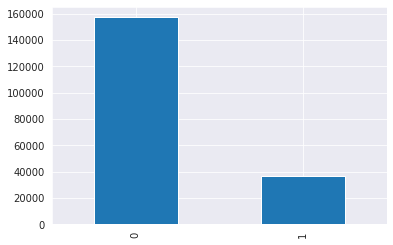

In [ ]:
print("Class Imbalance\n")
print(train.CHURN.value_counts(), "\n") 
train.CHURN.value_counts().plot.bar(); 

### Preprocess Data for Modelling
 > Cleaning
  - Drop MRG column
  - Remove outliers
  - Impute NaN by KNNImputer/SimpleImputer(mean/median for numerical and most frequent for categorical)

> Feature Engineering
 - Extract feature of users' rank by (Group of Region by Tenure) 
 - Extract feature users' rank  by TOPPACK
 - Balance Class Imbalance
 - Feature Union (K-best Selector and PCA components)

> Put all processes in Sklearn Pipeline



> Separate Y Labels from train set

In [ ]:
train, train_label = train.drop('CHURN', axis=1), train.CHURN 

In [ ]:
train_label.value_counts() 

0    157332
1     36532
Name: CHURN, dtype: int64

In [ ]:
train.shape

(193864, 18)

In [ ]:
test.shape

(34211, 18)

#### Define Custom Estimators and Functions for each Preprocessing steps


> Drop Columns

In [ ]:
class DropColumns(BaseEstimator, TransformerMixin):

  """
  Drop Columns not needed 
  """

  def __init__(self, cols_to_drop:list):
    self.cols_to_drop = cols_to_drop

  def fit(self, X:pd.DataFrame, y=None):
    self.X_copy_ = X.copy()

    return self

  def transform(self, X, y=None):
    self.X_copy_ = X.copy()
    self.X_copy_ = self.X_copy_.drop(self.cols_to_drop, axis=1)

    return self.X_copy_   


  def fit_transform(self, X:pd.DataFrame, y=None):
    self = self.fit(X)

    self.X_copy_ = self.transform(X)

    return self.X_copy_

In [ ]:
drop_col = DropColumns(cols_to_drop=['MRG', 'user_id'])   
train_process = drop_col.fit_transform(train)  
train_process    

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK
542316,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
59878,THIES,K > 24 month,11650.0,30.0,11682.0,3894.0,32.0,7119.0,23.0,468.0,54.0,0.0,NaN,60,Jokko_Daily,18.0
10729,SAINT-LOUIS,K > 24 month,1000.0,2.0,1000.0,333.0,2.0,NaN,7.0,45.0,NaN,NaN,NaN,22,All-net 500F=2000F;5d,2.0
456437,KAOLACK,K > 24 month,500.0,1.0,480.0,160.0,4.0,1875.0,14.0,1.0,NaN,NaN,NaN,20,"Data: 100 F=40MB,24H",2.0
273902,NaN,K > 24 month,11150.0,34.0,11750.0,3917.0,40.0,789.0,125.0,303.0,29.0,0.0,NaN,46,On net 200F=Unlimited _call24H,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392679,LOUGA,K > 24 month,500.0,1.0,500.0,167.0,1.0,0.0,9.0,8.0,15.0,NaN,NaN,20,All-net 500F=2000F;5d,1.0
494369,DAKAR,K > 24 month,1100.0,3.0,1098.0,366.0,3.0,216.0,27.0,1.0,2.0,NaN,NaN,20,"Data: 100 F=40MB,24H",2.0
59888,THIES,K > 24 month,1000.0,2.0,1000.0,333.0,2.0,NaN,34.0,43.0,2.0,NaN,NaN,13,All-net 500F =2000F_AllNet_Unlimited,1.0
561559,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN


> Median Imputation for Outlier values

In [ ]:
class ImputeOutlier(BaseEstimator, TransformerMixin):


  def __init__(self):
    pass 

  def fit(self, X:pd.DataFrame, y=None):
    self.X_copy_ = X.copy()
    self.X_cols_ = self.X_copy_.select_dtypes(include=['int64', 'float64']).columns.tolist()
 
    return self

  def transform(self, X, y=None):

      for col in self.X_cols_: 
        low  = self.X_copy_[col].quantile(0.05) 
        high = self.X_copy_[col].quantile(0.95)  

        self.X_copy_[col] = self.X_copy_[col].mask(self.X_copy_[col] > high, high) #np.where(self.X_copy_[col] > high, median,self.X_copy_[col])
        self.X_copy_[col] = self.X_copy_[col].mask(self.X_copy_[col] < low, low) #np.where(self.X_copy_[col] < low, median, self.X_copy_[col]) 
        
      return self.X_copy_


  def fit_transform(self, X:pd.DataFrame, y=None): 

    self = self.fit(X)
    self.X_copy_ = self.transform(X)


    return self.X_copy_ 

In [ ]:
imp_out = ImputeOutlier()
train_process = imp_out.fit_transform(train_process)  
train_process 

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK
542316,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
59878,THIES,K > 24 month,11650.0,30.0,11682.0,3894.0,32.0,7119.0,23.0,394.0,54.0,0.0,NaN,60,Jokko_Daily,18.0
10729,SAINT-LOUIS,K > 24 month,1000.0,2.0,1000.0,333.0,2.0,NaN,7.0,45.0,NaN,NaN,NaN,22,All-net 500F=2000F;5d,2.0
456437,KAOLACK,K > 24 month,500.0,1.0,480.0,160.0,4.0,1875.0,14.0,1.0,NaN,NaN,NaN,20,"Data: 100 F=40MB,24H",2.0
273902,NaN,K > 24 month,11150.0,34.0,11750.0,3917.0,40.0,789.0,125.0,303.0,29.0,0.0,NaN,46,On net 200F=Unlimited _call24H,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392679,LOUGA,K > 24 month,500.0,1.0,500.0,167.0,1.0,0.0,9.0,8.0,15.0,NaN,NaN,20,All-net 500F=2000F;5d,1.0
494369,DAKAR,K > 24 month,1100.0,3.0,1098.0,366.0,3.0,216.0,27.0,1.0,2.0,NaN,NaN,20,"Data: 100 F=40MB,24H",2.0
59888,THIES,K > 24 month,1000.0,2.0,1000.0,333.0,2.0,NaN,34.0,43.0,2.0,NaN,NaN,13,All-net 500F =2000F_AllNet_Unlimited,1.0
561559,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN


In [ ]:
check_outliers(train_process) 

{'MONTANT': True, 'FREQUENCE_RECH': True, 'REVENUE': True, 'ARPU_SEGMENT': True, 'FREQUENCE': False, 'DATA_VOLUME': True, 'ON_NET': True, 'ORANGE': True, 'TIGO': True, 'ZONE1': True, 'ZONE2': True, 'REGULARITY': False, 'FREQ_TOP_PACK': True}
(193864, 16)


,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,FREQ_TOP_PACK
542316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59878,11650.0,30.0,11682.0,3894.0,7119.0,23.0,394.0,54.0,0.0,NaN,18.0
10729,1000.0,2.0,1000.0,333.0,NaN,7.0,45.0,NaN,NaN,NaN,2.0
456437,500.0,1.0,480.0,160.0,1875.0,14.0,1.0,NaN,NaN,NaN,2.0
273902,11150.0,34.0,11750.0,3917.0,789.0,125.0,303.0,29.0,0.0,NaN,31.0
...,...,...,...,...,...,...,...,...,...,...,...
392679,500.0,1.0,500.0,167.0,0.0,9.0,8.0,15.0,NaN,NaN,1.0
494369,1100.0,3.0,1098.0,366.0,216.0,27.0,1.0,2.0,NaN,NaN,2.0
59888,1000.0,2.0,1000.0,333.0,NaN,34.0,43.0,2.0,NaN,NaN,1.0
561559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


no more outlier values

> Impute NaNs in categorical values


In [ ]:
cat_imp = SimpleImputer(strategy='most_frequent')  

In [ ]:
train_cat = train_process.select_dtypes('object')
train_cat  = cat_imp.fit_transform(train_cat)
train_cat

array([['DAKAR', 'K > 24 month', 'All-net 500F=2000F;5d'],
       ['THIES', 'K > 24 month', 'Jokko_Daily'],
       ['SAINT-LOUIS', 'K > 24 month', 'All-net 500F=2000F;5d'],
       ...,
       ['THIES', 'K > 24 month', 'All-net 500F =2000F_AllNet_Unlimited'],
       ['DAKAR', 'K > 24 month', 'All-net 500F=2000F;5d'],
       ['DAKAR', 'K > 24 month', 'Data:490F=1GB,7d']], dtype=object)

In [ ]:
# train_cat = pd.DataFrame(data=train_cat, columns=  train_process.select_dtypes('object').columns.tolist())
# train_cat.isna().any()

In [ ]:
train_cat

array([['DAKAR', 'K > 24 month', 'All-net 500F=2000F;5d'],
       ['THIES', 'K > 24 month', 'Jokko_Daily'],
       ['SAINT-LOUIS', 'K > 24 month', 'All-net 500F=2000F;5d'],
       ...,
       ['THIES', 'K > 24 month', 'All-net 500F =2000F_AllNet_Unlimited'],
       ['DAKAR', 'K > 24 month', 'All-net 500F=2000F;5d'],
       ['DAKAR', 'K > 24 month', 'Data:490F=1GB,7d']], dtype=object)

> Impute NaNs in numeric values


In [ ]:
num_imp = SimpleImputer(strategy='mean')  

In [ ]:
train_num = train_process.select_dtypes(['float64', 'int64'])
train_num  = num_imp.fit_transform(train_num)
train_num 

array([[5.07889426e+03, 1.09059206e+01, 5.05916435e+03, ...,
        4.61821769e+00, 1.00000000e+00, 8.49033567e+00],
       [1.16500000e+04, 3.00000000e+01, 1.16820000e+04, ...,
        4.61821769e+00, 6.00000000e+01, 1.80000000e+01],
       [1.00000000e+03, 2.00000000e+00, 1.00000000e+03, ...,
        4.61821769e+00, 2.20000000e+01, 2.00000000e+00],
       ...,
       [1.00000000e+03, 2.00000000e+00, 1.00000000e+03, ...,
        4.61821769e+00, 1.30000000e+01, 1.00000000e+00],
       [5.07889426e+03, 1.09059206e+01, 5.05916435e+03, ...,
        4.61821769e+00, 2.00000000e+00, 8.49033567e+00],
       [7.20000000e+03, 1.60000000e+01, 7.19000000e+03, ...,
        0.00000000e+00, 6.00000000e+01, 8.00000000e+00]])

In [ ]:
# train_num = pd.DataFrame(data=train_num, columns=  train_process.select_dtypes(['float64', 'int64']).columns.tolist())
# train_num.isna().any()

In [ ]:
train_num

array([[5.07889426e+03, 1.09059206e+01, 5.05916435e+03, ...,
        4.61821769e+00, 1.00000000e+00, 8.49033567e+00],
       [1.16500000e+04, 3.00000000e+01, 1.16820000e+04, ...,
        4.61821769e+00, 6.00000000e+01, 1.80000000e+01],
       [1.00000000e+03, 2.00000000e+00, 1.00000000e+03, ...,
        4.61821769e+00, 2.20000000e+01, 2.00000000e+00],
       ...,
       [1.00000000e+03, 2.00000000e+00, 1.00000000e+03, ...,
        4.61821769e+00, 1.30000000e+01, 1.00000000e+00],
       [5.07889426e+03, 1.09059206e+01, 5.05916435e+03, ...,
        4.61821769e+00, 2.00000000e+00, 8.49033567e+00],
       [7.20000000e+03, 1.60000000e+01, 7.19000000e+03, ...,
        0.00000000e+00, 6.00000000e+01, 8.00000000e+00]])

> merge columns

In [ ]:
# train_process = train_cat.merge(train_num, left_index=True, right_index=True)
# train_process.isna().any()

In [ ]:
train_process = np.concatenate((train_cat, train_num), axis=1)

In [ ]:
train_process 

array([['DAKAR', 'K > 24 month', 'All-net 500F=2000F;5d', ...,
        4.618217691548833, 1.0, 8.490335670807674],
       ['THIES', 'K > 24 month', 'Jokko_Daily', ..., 4.618217691548833,
        60.0, 18.0],
       ['SAINT-LOUIS', 'K > 24 month', 'All-net 500F=2000F;5d', ...,
        4.618217691548833, 22.0, 2.0],
       ...,
       ['THIES', 'K > 24 month', 'All-net 500F =2000F_AllNet_Unlimited',
        ..., 4.618217691548833, 13.0, 1.0],
       ['DAKAR', 'K > 24 month', 'All-net 500F=2000F;5d', ...,
        4.618217691548833, 2.0, 8.490335670807674],
       ['DAKAR', 'K > 24 month', 'Data:490F=1GB,7d', ..., 0.0, 60.0, 8.0]],
      dtype=object)

> Feature Engineering
 - Extract feature of users' rank by (Group of Region by Tenure) 
 - Extract feature users' rank  by TOPPACK
 - Balance Class Imbalance
 - Feature Union (K-best Selector and PCA components)

 - Extract feature of users' rank by (Group of Region by Tenure) 
 - Extract feature users' rank  by TOPPACK

In [ ]:
# train_process_copy = train_process.copy() 

In [ ]:
# train_process_copy.TENURE.value_counts()

labelEncode Tenure

In [ ]:
# label_encoder = LabelEncoder()
# train_process_copy.TENURE = label_encoder.fit_transform(train_process_copy.TENURE) 
# train_process_copy

In [ ]:
# top3_region = train_process_copy.groupby(['REGION'])['TENURE'].sum().sort_values(ascending=False).head(3)
# top3_region

In [ ]:
# top3_region=top3_region.index.tolist() 
# top3_region 

In [ ]:
# top3_region[0]

In [ ]:
# x = train_process_copy.REGION.copy()
# x 

In [ ]:
# x.where((x != 1) | (x!=2) | (x !=3)) 

In [ ]:
# x = train_process_copy.REGION.copy()
# x = np.where(x == top3_region[0], 3, x)
# x = np.where(x == top3_region[1], 2, x) 
# x = np.where(x == top3_region[2], 1, x)
# x = np.where((x != 1) & (x!=2) & (x!=3), 0, x)
# x  

In [ ]:
# set(x) 

In [ ]:
train_cols = train.drop(columns=['user_id', 'MRG']).columns.to_list()
len(train_cols )

16

In [ ]:
train_cols

['REGION',
 'TENURE',
 'MONTANT',
 'FREQUENCE_RECH',
 'REVENUE',
 'ARPU_SEGMENT',
 'FREQUENCE',
 'DATA_VOLUME',
 'ON_NET',
 'ORANGE',
 'TIGO',
 'ZONE1',
 'ZONE2',
 'REGULARITY',
 'TOP_PACK',
 'FREQ_TOP_PACK']

> Define estimator to extract rank features

In [ ]:
class Ranker(BaseEstimator, TransformerMixin): 

  from sklearn.preprocessing import LabelEncoder

  


  def __init__(self, group_cols:list , value_col:str, columns=None):
    self.group_cols = group_cols
    self.value_col = value_col 

    self.label_encoder = LabelEncoder()

    if columns is None:
      self.columns= [ 'REGION',
  'TENURE',
  'TOP_PACK', 
  'MONTANT', 
  'FREQUENCE_RECH',
  'REVENUE',
  'ARPU_SEGMENT',
  'FREQUENCE',
  'DATA_VOLUME', 
  'ON_NET',
  'ORANGE',
  'TIGO', 
  'ZONE1',
  'ZONE2',
  'REGULARITY',
  'FREQ_TOP_PACK'
      ]

  def fit(self, X, y=None): 

    self.X_copy = pd.DataFrame(data=X, columns=self.columns)


    self.X_copy[self.value_col] = self.label_encoder.fit_transform(self.X_copy[self.value_col])
    

    return self


  def transform(self, X, y=None):

    self.X_copy = pd.DataFrame(data=X, columns=self.columns)

    self.X_copy[self.value_col] = self.label_encoder.fit_transform(self.X_copy[self.value_col])


    for col in self.group_cols:

      self.top3_ = self.X_copy.groupby([col])[self.value_col].sum().sort_values(ascending=False).head(3) 

      self.top3_ = self.top3_.index.tolist()

      #print(self.top3_)

      self.X_copy[col] = np.where(self.X_copy[col] == 
                                            self.top3_[0], 3, self.X_copy[col]) 
      
      self.X_copy[col] = np.where(self.X_copy[col] == 
                                            self.top3_[1], 2, self.X_copy[col])  
      
      self.X_copy[col] = np.where(self.X_copy[col] ==  
                                            self.top3_[2], 1, self.X_copy[col])
      
      
      self.X_copy[col] = np.where((self.X_copy[col] != 1 ) & (
          self.X_copy[col] !=2 ) & (self.X_copy[col] !=3 ), 0, self.X_copy[col])


    return self.X_copy


  def fit_transform(self, X, y=None):

    self = self.fit(X)

    self.X_copy = self.transform(X)


    return self.X_copy 

In [ ]:
ranker = Ranker(group_cols=['REGION', 'TOP_PACK'], value_col='TENURE')
train_process_copy = train_process.copy()  
train_process_copy = ranker.fit_transform(train_process_copy)  

In [ ]:
train_process_copy 

,REGION,TENURE,TOP_PACK,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK
0,3,7,3,5078.89,10.9059,5059.16,1686.36,13.3444,2477.64,184.792,77.9462,17.2977,4.09905,4.61822,1,8.49034
1,2,7,0,11650,30,11682,3894,32,7119,23,394,54,0,4.61822,60,18
2,1,7,3,1000,2,1000,333,2,2477.64,7,45,17.2977,4.09905,4.61822,22,2
3,0,7,0,500,1,480,160,4,1875,14,1,17.2977,4.09905,4.61822,20,2
4,3,7,2,11150,34,11750,3917,40,789,125,303,29,0,4.61822,46,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193859,0,7,3,500,1,500,167,1,0,9,8,15,4.09905,4.61822,20,1
193860,3,7,0,1100,3,1098,366,3,216,27,1,2,4.09905,4.61822,20,2
193861,2,7,0,1000,2,1000,333,2,2477.64,34,43,2,4.09905,4.61822,13,1
193862,3,7,3,5078.89,10.9059,5059.16,1686.36,13.3444,2477.64,184.792,77.9462,17.2977,4.09905,4.61822,2,8.49034


#### save cleaned data for modelling


In [ ]:
train_process_copy.to_csv('/content/drive/My Drive/Zindi-Competionts/customer-churn-prediction/datasets/clean_train.csv',index=False)

In [ ]:
train_process_copy  = pd.read_csv('/content/drive/My Drive/Zindi-Competionts/customer-churn-prediction/datasets/clean_train.csv') 

--- 

In [ ]:
train_process_copy 

,REGION,TENURE,TOP_PACK,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK
0,3,7,3,5078.894264,10.905921,5059.164349,1686.364679,13.34441,2477.643433,184.792221,77.946193,17.297697,4.099048,4.618218,1.0,8.490336
1,2,7,0,11650.000000,30.000000,11682.000000,3894.000000,32.00000,7119.000000,23.000000,394.000000,54.000000,0.000000,4.618218,60.0,18.000000
2,1,7,3,1000.000000,2.000000,1000.000000,333.000000,2.00000,2477.643433,7.000000,45.000000,17.297697,4.099048,4.618218,22.0,2.000000
3,0,7,0,500.000000,1.000000,480.000000,160.000000,4.00000,1875.000000,14.000000,1.000000,17.297697,4.099048,4.618218,20.0,2.000000
4,3,7,2,11150.000000,34.000000,11750.000000,3917.000000,40.00000,789.000000,125.000000,303.000000,29.000000,0.000000,4.618218,46.0,31.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193859,0,7,3,500.000000,1.000000,500.000000,167.000000,1.00000,0.000000,9.000000,8.000000,15.000000,4.099048,4.618218,20.0,1.000000
193860,3,7,0,1100.000000,3.000000,1098.000000,366.000000,3.00000,216.000000,27.000000,1.000000,2.000000,4.099048,4.618218,20.0,2.000000
193861,2,7,0,1000.000000,2.000000,1000.000000,333.000000,2.00000,2477.643433,34.000000,43.000000,2.000000,4.099048,4.618218,13.0,1.000000
193862,3,7,3,5078.894264,10.905921,5059.164349,1686.364679,13.34441,2477.643433,184.792221,77.946193,17.297697,4.099048,4.618218,2.0,8.490336


 - Balance Class Imbalance
 - Feature Union (K-best Selector and PCA components)

In [ ]:
# scale data with standarscaler
scaler = RobustScaler() 

In [ ]:
scaled_train = scaler.fit_transform(train_process_copy)
scaled_train 

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.52272727,  0.        ],
       [-0.5       ,  0.        , -1.        , ...,  0.        ,
         0.81818182,  2.117807  ],
       [-1.        ,  0.        ,  0.        , ...,  0.        ,
        -0.04545455, -1.445401  ],
       ...,
       [-0.5       ,  0.        , -1.        , ...,  0.        ,
        -0.25      , -1.6681015 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.5       ,  0.        ],
       [ 0.        ,  0.        , -0.66666667, ..., -4.61821769,
         0.81818182, -0.109198  ]])

In [ ]:
scaled_train.shape

(193864, 16)

In [ ]:
smote = SMOTE(random_state=0) 

In [ ]:
X, y = smote.fit_resample(scaled_train, train_label)

In [ ]:
X 

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.52272727,  0.        ],
       [-0.5       ,  0.        , -1.        , ...,  0.        ,
         0.81818182,  2.117807  ],
       [-1.        ,  0.        ,  0.        , ...,  0.        ,
        -0.04545455, -1.445401  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.31818182,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.52272727,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.5       ,  0.        ]])

In [ ]:
pd.Series(y).value_counts() 

1    157332
0    157332
dtype: int64

In [ ]:
corr = pd.DataFrame(data=X, columns=train_process_copy.columns.to_list()).join(pd.DataFrame(y, columns=['label']))
corr 

,REGION,TENURE,TOP_PACK,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,label
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.522727,0.000000,1
1,-0.5,0.0,-1.000000,2.134242,2.764885,2.097052,2.097785,2.540107,2.083528,-0.936340,5.454264,5.827893,-4.099048,0.0,0.818182,2.117807,0
2,-1.0,0.0,0.000000,-1.324792,-1.289607,-1.285292,-1.286023,-1.544632,0.000000,-1.028936,-0.568565,0.000000,0.000000,0.0,-0.045455,-1.445401,0
3,-1.5,0.0,-1.000000,-1.487188,-1.434410,-1.449945,-1.450414,-1.272316,-0.270530,-0.988425,-1.327890,0.000000,0.000000,0.0,-0.090909,-1.445401,0
4,0.0,0.0,-0.333333,1.971846,3.344099,2.118584,2.119641,3.629371,-0.758040,-0.346035,3.883841,1.858188,-4.099048,0.0,0.500000,5.012914,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314659,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.342214,0.410053,-1.041696,0.000000,0.0,0.545455,0.000000,1
314660,0.0,-2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.477273,0.000000,1
314661,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.318182,0.000000,1
314662,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.522727,0.000000,1


In [ ]:
corr.isna().any()

REGION            False
TENURE            False
TOP_PACK          False
MONTANT           False
FREQUENCE_RECH    False
REVENUE           False
ARPU_SEGMENT      False
FREQUENCE         False
DATA_VOLUME       False
ON_NET            False
ORANGE            False
TIGO              False
ZONE1             False
ZONE2             False
REGULARITY        False
FREQ_TOP_PACK     False
label             False
dtype: bool

In [ ]:
# f, ax = plt.subplots(figsize=(20, 25))  
# ax = sns.heatmap(corr, vmin=0, vmax=1) 
corr.corr()  

,REGION,TENURE,TOP_PACK,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,label
REGION,1.000000,-0.028896,0.221631,0.007697,-0.009568,0.000921,0.000915,-0.013942,0.079697,-0.097381,-0.023932,0.004089,0.025336,0.027949,-0.398095,-0.000495,0.447510
TENURE,-0.028896,1.000000,-0.024192,0.013201,0.006881,0.014453,0.014454,0.007790,-0.008336,0.005708,0.018738,0.010969,0.002995,-0.000868,0.045218,0.007899,-0.051876
TOP_PACK,0.221631,-0.024192,1.000000,-0.071482,-0.068535,-0.090949,-0.090956,-0.094430,-0.204325,-0.091574,-0.014940,-0.001196,0.025779,-0.002752,-0.540729,0.032916,0.408662
MONTANT,0.007697,0.013201,-0.071482,1.000000,0.850763,0.948590,0.948581,0.802063,0.356537,0.432938,0.662312,0.390457,0.091377,0.143462,0.382596,0.732207,-0.093854
FREQUENCE_RECH,-0.009568,0.006881,-0.068535,0.850763,1.000000,0.812315,0.812308,0.919950,0.261849,0.435040,0.533441,0.322761,0.032487,0.084660,0.371665,0.846442,-0.097229
REVENUE,0.000921,0.014453,-0.090949,0.948590,0.812315,1.000000,1.000000,0.847234,0.365477,0.436299,0.666679,0.389456,0.092199,0.143927,0.395784,0.729149,-0.104014
ARPU_SEGMENT,0.000915,0.014454,-0.090956,0.948581,0.812308,1.000000,1.000000,0.847237,0.365477,0.436296,0.666671,0.389448,0.092198,0.143924,0.395790,0.729137,-0.104019
FREQUENCE,-0.013942,0.007790,-0.094430,0.802063,0.919950,0.847234,0.847237,1.000000,0.293843,0.413297,0.497667,0.291956,0.028447,0.086221,0.394844,0.810855,-0.112810
DATA_VOLUME,0.079697,-0.008336,-0.204325,0.356537,0.261849,0.365477,0.365477,0.293843,1.000000,-0.004331,0.045718,0.018599,0.002975,0.019319,0.221435,0.192635,-0.057351
ON_NET,-0.097381,0.005708,-0.091574,0.432938,0.435040,0.436299,0.436296,0.413297,-0.004331,1.000000,0.375125,0.245116,-0.002108,-0.017155,0.243193,0.413321,-0.066752


#### Feature Union K-Best and PCA Components

- select the optimal k for k-best

In [ ]:
KBest = SelectKBest(score_func = f_classif, k = 'all')
KBest = KBest.fit(X,y)  


In [ ]:
kb_scores = pd.DataFrame({'features': train_process_copy.columns, 'f_classif': KBest.scores_, 'pValue': KBest.pvalues_ }).sort_values(by='f_classif', 
                                                                                                                                      ascending=False)
kb_scores 

,features,f_classif,pValue
14,REGULARITY,222636.336823,0.000000e+00
0,REGION,78795.832389,0.000000e+00
2,TOP_PACK,63085.573465,0.000000e+00
7,FREQUENCE,4056.056356,0.000000e+00
6,ARPU_SEGMENT,3441.888473,0.000000e+00
5,REVENUE,3441.513215,0.000000e+00
4,FREQUENCE_RECH,3003.032830,0.000000e+00
3,MONTANT,2796.334811,0.000000e+00
9,ON_NET,1408.369158,1.538636e-307
15,FREQ_TOP_PACK,1256.448914,1.152769e-274


In [ ]:
kb_scores.shape

(16, 3)

I would taek the first 12 features with thousandth scores 

In [ ]:
kbest_cols = kb_scores.features.iloc[:12].tolist()
kbest_cols 

['REGULARITY',
 'REGION',
 'TOP_PACK',
 'FREQUENCE',
 'ARPU_SEGMENT',
 'REVENUE',
 'FREQUENCE_RECH',
 'MONTANT',
 'ON_NET',
 'FREQ_TOP_PACK',
 'ORANGE',
 'DATA_VOLUME']

In [ ]:
KBest = SelectKBest(score_func = f_classif, k = 12)
KBest_data = KBest.fit_transform(X,y) 

In [ ]:
KBest_data.shape

(314664, 12)

- PCA components

- get optimal k

In [ ]:
pca = TruncatedSVD(n_components = X.shape[1]-1).fit(X)
pca

TruncatedSVD(algorithm='randomized', n_components=15, n_iter=5,
             random_state=None, tol=0.0)

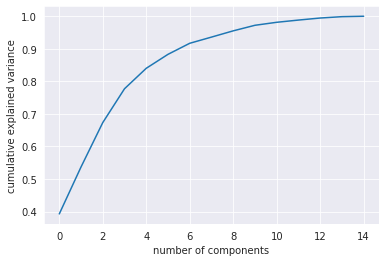

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

14 components explains the X 100%

> Indented block



In [ ]:
pca = TruncatedSVD(n_components = 14, random_state=0).fit(X)
pca

TruncatedSVD(algorithm='randomized', n_components=14, n_iter=5, random_state=0,
             tol=0.0)

In [ ]:
pca_ratio = pca.explained_variance_ratio_
pca_ratio 

array([0.39287352, 0.14422495, 0.13631951, 0.10390176, 0.06283773,
       0.04285913, 0.03393778, 0.01899398, 0.01921025, 0.01706656,
       0.00919268, 0.0068172 , 0.00630964, 0.00413914])

I would be optimaisng for 95% exaplainability

In [ ]:
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
                                     
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [ ]:
select_n_components(pca_ratio, goal_var=.95)

9

### 9 components provides 95% explainability

In [ ]:
# pca_components

### Decomposing Features into Components

In [ ]:
def pca_call(data, n_components, algo='randomized', n_iter=100, random_seed =123, tol=0.0) -> np.array:

  pca = TruncatedSVD(n_components=n_components, algorithm=algo, 
                     n_iter=n_iter, random_state=random_seed, tol=tol)
  
  data_reduced = pca.fit_transform(data) 

  return data_reduced, pca

In [ ]:
pca_data, pca = pca_call(X, n_components=9)

In [ ]:
pca_data.shape 

(314664, 9)

#### Combine PCA components and K-best features

In [ ]:
X_joined = np.concatenate((KBest_data, pca_data), axis=1)

In [ ]:
X_joined.shape[0] == y.shape[0]

True

In [ ]:
X_joined.shape

(314664, 21)

> test  pipeline ...


In [ ]:

feature_pipe = FeatureUnion(transformer_list=[('pca', TruncatedSVD(n_components=9)) ,
                                              ('k_best', SelectKBest(score_func = f_classif, k = 'all'))            
                              ])


full_pipe = ImbPipe(steps=[('smt',  SMOTE()),  ('scaler', RobustScaler()), ('feature_pipe', feature_pipe)], verbose=True) 

In [ ]:
print(train_process_copy.shape)
print(train_label.shape) 

(193864, 16)
(193864,)


In [ ]:
train_process_copy.head(1)

,REGION,TENURE,TOP_PACK,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK
0,3,7,3,5078.894264,10.905921,5059.164349,1686.364679,13.34441,2477.643433,184.792221,77.946193,17.297697,4.099048,4.618218,1.0,8.490336


In [ ]:
train_label.head(1)

542316    1
Name: CHURN, dtype: int64

In [ ]:
full_pipe.fit_transform(train_process_copy, train_label) 

array([[-1.34189444e-03, -1.14221203e-02,  2.47670027e-03, ...,
         0.00000000e+00, -2.05882353e-01,  0.00000000e+00],
       [ 3.79293956e+01,  5.16524920e+00, -4.22121342e+00, ...,
         0.00000000e+00,  1.52941176e+00,  4.07947207e+00],
       [-7.36234450e-01, -5.04738555e+00,  1.74317430e-01, ...,
         0.00000000e+00,  4.11764706e-01, -2.78423530e+00],
       ...,
       [-4.55673662e-01, -3.09576260e+00, -1.06456795e-01, ...,
         0.00000000e+00, -1.66419605e-01,  0.00000000e+00],
       [-1.34189444e-03, -1.14221203e-02,  2.47670027e-03, ...,
         0.00000000e+00, -2.05882353e-01,  0.00000000e+00],
       [-3.83398412e-04, -3.26346293e-03,  7.07628650e-04, ...,
         0.00000000e+00, -5.88235294e-02,  0.00000000e+00]])

## Modelling

Algorithms:

- logisticRegression - Basemodel

- SVC

- Catboost

- XGboost

- LGBM

Techniques

- cross validation

- hp-tuning

- over-sampling imbalance

>> Import needed libraries

split to X & Y

In [ ]:
X= train.copy()
y = train_label.copy()

split to train and test set

In [156]:
X_train, X_eval, y_train, y_eval = train_test_split(
   X,
   y,
    test_size=0.33,
    shuffle=True,
    stratify = y,
    random_state=0)

In [157]:
print(X_train.shape) 
print(y_train.shape) 

(129888, 18)
(129888,)


### Build Pipeline

 #### Preprocessing Pipeline

In [158]:
num_features = train.select_dtypes(include='number').columns.tolist()
num_features

['MONTANT',
 'FREQUENCE_RECH',
 'REVENUE',
 'ARPU_SEGMENT',
 'FREQUENCE',
 'DATA_VOLUME',
 'ON_NET',
 'ORANGE',
 'TIGO',
 'ZONE1',
 'ZONE2',
 'REGULARITY',
 'FREQ_TOP_PACK']

In [159]:
cat_features = train.select_dtypes(include='object').drop(['user_id', 'MRG'], axis=1).columns.tolist() 
cat_features 

['REGION', 'TENURE', 'TOP_PACK']

In [162]:
process_pipe1 = Pipeline(steps=[('drop_cols',  DropColumns(cols_to_drop=['MRG', 'user_id'])),  
                                ('impute_outlier', ImputeOutlier())])  

In [163]:
process_pipe2 = ColumnTransformer([('cat_impute', SimpleImputer(strategy='most_frequent'), cat_features),
                                              ('num_impute', SimpleImputer(strategy='mean'),num_features)
                                  ], remainder = "drop")

In [164]:
process_pipe3 =  Pipeline(steps=[('ranker', Ranker(group_cols=['REGION', 'TOP_PACK'], value_col='TENURE')),
                                ]) 

In [165]:
feature_pipe = FeatureUnion(transformer_list=[('pca', PCA(n_components=9)) ,
                                              ('k_best', SelectKBest(score_func = f_classif, k = 12))            
                              ])


process_pipe4 = Pipeline(steps=[('scaler', StandardScaler()), ('feature_pipe', feature_pipe)], verbose=True) 

In [166]:
process_pipe_full = Pipeline(steps=[('pipe1', process_pipe1), ('pipe2', process_pipe2),
                                                 ('pipe3', process_pipe3),('pipe4', process_pipe4)])  

In [167]:
processed_pipe = process_pipe_full.fit(X=train, y=train_label) 

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ...... (step 2 of 2) Processing feature_pipe, total=   0.7s


In [ ]:

processed_pipe.named_steps 

{'pipe1': Pipeline(memory=None,
          steps=[('drop_cols', DropColumns(cols_to_drop=['MRG', 'user_id'])),
                 ('impute_outlier', ImputeOutlier())],
          verbose=False),
 'pipe2': ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                   transformer_weights=None,
                   transformers=[('cat_impute',
                                  SimpleImputer(add_indicator=False, copy=True,
                                                fill_value=None,
                                                missing_values=nan,
                                                strategy='most_frequent',
                                                verbose=0),
                                  ['REGION', 'TENURE', 'TOP_PACK']),
                                 ('num_impute',
                                  SimpleImputer(add_indicator=False, copy=True,
                                                fill_value=None,
                          

In [ ]:
processed_data = processed_pipe.transform(train) 

In [ ]:
processed_data.shape

(193864, 21)

In [ ]:
train.shape

(193864, 18)

In [ ]:
processed_data 

array([[-0.03097276, -0.01804538,  0.01176833, ...,  0.        ,
        -0.52272727,  0.        ],
       [ 8.4485491 , -3.76383298, -3.33873823, ..., -0.93633973,
         0.81818182,  2.117807  ],
       [-3.10557306, -1.33024193,  0.6622033 , ..., -1.02893649,
        -0.04545455, -1.445401  ],
       ...,
       [-4.21974444,  0.64203446, -0.04069711, ..., -0.87267945,
        -0.25      , -1.6681015 ],
       [-0.02962612, -0.01726079,  0.01125666, ...,  0.        ,
        -0.5       ,  0.        ],
       [ 0.82597791,  0.05102551,  0.05063304, ..., -1.02893649,
         0.81818182, -0.109198  ]])

In [ ]:
processed_data.shape

(193864, 21)

In [ ]:
!pip install catboost
!pip install xgboost

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.svm import SVC
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier 
from sklearn.metrics import log_loss, balanced_accuracy_score

In [ ]:
smt = SMOTE()


#### LogisticRegression/LogisticRegressionCV


params for LogRegCV

In [ ]:
scv = StratifiedKFold(n_splits=5, shuffle=True)
log_score=make_scorer(score_func=log_loss) 
scoring = log_score
class_weight = 'balanced'
n_jobs = 4
random_state = 123

In [148]:
logit_model  = Pipeline(steps=[('process', process_pipe_full), ('logistic',LogisticRegression(class_weight='balanced', random_state=0))], verbose=True)

In [ ]:
# log_smt  = SMOTE

In [149]:
logit_model.fit(X_train2, y_train2) 

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ...... (step 2 of 2) Processing feature_pipe, total=   0.6s
[Pipeline] ........... (step 1 of 2) Processing process, total=  32.1s
[Pipeline] .......... (step 2 of 2) Processing logistic, total=   1.4s


Pipeline(memory=None,
         steps=[('process',
                 Pipeline(memory=None,
                          steps=[('pipe1',
                                  Pipeline(memory=None,
                                           steps=[('drop_cols',
                                                   DropColumns(cols_to_drop=['MRG',
                                                                             'user_id'])),
                                                  ('impute_outlier',
                                                   ImputeOutlier())],
                                           verbose=False)),
                                 ('pipe2',
                                  ColumnTransformer(n_jobs=None,
                                                    remainder='drop',
                                                    sparse_threshold=0.3,
                                                    transformer_weights=None,
                                            

In [150]:
log_pred = logit_model.predict_proba(X_train2)[:,1]

In [151]:
log_pred.shape

(139581,)

In [154]:
# log_loss(y_val, log_pred)

#### SVC

In [ ]:
svc_model  = Pipeline(steps=[('process', process_pipe_full), ('svc',SVC(class_weight='balanced', verbose=True, probability=True, random_state=0))], verbose=True)

In [ ]:
# svc_model.fit(X_train2, y_train2)

In [ ]:


# svc_model.fit(X_train2, y_train2;)

In [ ]:
# svc_pred = svc_model.predict_proba(X_train2)[:1]

In [ ]:
# svc_pred

### XGBoost

In [ ]:
xgb = XGBClassifier(n_estimators=1000,random_seed = 10, use_best_model=True, eval_metric = 'logloss')

In [ ]:
xgb_model = Pipeline(steps=[('process', process_pipe_full), ('xgb', xgb)], verbose=True)

In [ ]:
xgb_model.fit(X_train2,y_train2,eval_set=[(X_train2,y_train2),(X_val, y_val)], early_stopping_rounds=100,verbose=100)

In [ ]:
xgb_pred  = xgb_model.predict_proba(X_val)[:,1]

### CatBoost

In [ ]:
cat = CatBoostClassifier(n_estimators=1000,random_seed = 10, use_best_model=True, eval_metric = 'logloss')

In [ ]:
cat_model = Pipeline(steps=[('process', process_pipe_full), ('cat', cat)], verbose=True)

In [ ]:
cat_model.fit(X_train2,y_train2,eval_set=[(X_train2,y_train2),(X_val, y_val)], early_stopping_rounds=100,verbose=100)

In [ ]:
cat_pred  = cat_model.predict_proba(X_val)[:,1]

#### Measure model's performances

In [ ]:

log_metric = PredMetrics(X_train2, y_train2, log_pred, y_val, logit_model, log_score, cv=cv) 

In [ ]:
print(log_metric.class_report())